# Question Classification

**Aim**: Establish baseline(s) and subsequent models for question classification using the Trec(6) dataset.

In [85]:
'''
Imports
'''

import os, re, string, sys
import nltk
from nltk.tokenize import word_tokenize 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#import nlu

***

In [112]:
'''
Load/parse dataset
'''

xtrain = []
ytrain =[]
xtest = []
ytest = []    

# Train
with open("../../data/question_classification/trec_train.txt", 'rb') as f:
    questions = [x.decode('utf8').strip() for x in f.readlines()]
    for q in questions:
        splt = q.replace("\n", "").split(":")
        ytrain.append(splt[0])
        xtrain.append(" ".join(splt[1].split(" ")[1:]))
        
# Test
with open("../../data/question_classification/trec_test.txt", 'rb') as f:
    questions = [x.decode('utf8').strip() for x in f.readlines()]
    for q in questions:
        splt = q.replace("\n", "").split(":")
        ytest.append(splt[0])
        xtest.append(" ".join(splt[1].split(" ")[1:]))
        
classes = dict(enumerate(list(set(ytrain))))
reverse_classes = {v: k for k, v in classes.items()}

print("Classes: ", list(reverse_classes.keys()))
print("Classes counts:")
for cls in list(reverse_classes.keys()):
    print("- {}: {}".format(cls, len([x for x in ytrain if x == cls])))

Classes:  ['ABBR', 'NUM', 'LOC', 'DESC', 'ENTY', 'HUM']
Classes counts:
- ABBR: 86
- NUM: 896
- LOC: 835
- DESC: 1162
- ENTY: 1250
- HUM: 1223


In [72]:
'''
Preprocess data
'''

def preprocess_text(data):
    # Remove punctuation
    exclude = set(string.punctuation)
    data = [''.join(ch for ch in x if ch not in exclude).strip() for x in data]
    
    # Remove multi-spaces
    data = [re.sub(' +', ' ', x) for x in data]
    return data

xtrain = preprocess_text(xtrain)
xtest = preprocess_text(xtest)

print("Training instances: ", len(xtrain))
print("Testing instances: ", len(xtest))
print("\nTraining examples:")
print(xtrain[:5])

Training instances:  5452
Testing instances:  500

Training examples:
['How did serfdom develop in and then leave Russia', 'What films featured the character Popeye Doyle', 'How can I find a list of celebrities real names', 'What fowl grabs the spotlight after the Chinese Year of the Monkey', 'What is the full form of com']


***

In [118]:
'''
Util functions
'''

def plot_confusion_matrix(test_predictions):
    cm = confusion_matrix(ytest, test_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(classes.values())[::-1])
    disp.plot(xticks_rotation='vertical')

***

## Baseline 1 - Question words

Create and test a simple baseline that makes use of question words to classify questions into one of the 6 question classes.

In [93]:
'''
Establish baseline 1
'''
        
def get_named_entities(tokens):
    entities = nltk.chunk.ne_chunk(nltk.pos_tag(tokens))
    return entities

# Jonathan's baseline adapted
class SimpleBaseline:
    def __init__(self):
        self.categories = classes.keys()
                            
    def classify_question(self, question):
        question_tokens = word_tokenize(question) 
        words_and_labels = get_named_entities(question_tokens)
        entities = [ne for ne in words_and_labels if isinstance(ne, nltk.tree.Tree)]

        labels = [e.label() for e in entities]

        who_condition = "who" in [t.lower() for t in question_tokens]
        whose_condition = "whose" in [t.lower() for t in question_tokens]
        what_condition = "what" in [t.lower() for t in question_tokens]
        where_condition = "where" in [t.lower() for t in question_tokens]
        when_condition = "when" in [t.lower() for t in question_tokens]
        why_condition = "why" in [t.lower() for t in question_tokens]
        how_condition = "how" in [t.lower() for t in question_tokens]
        
        named_person_condition = "PERSON" in labels

        if who_condition and not named_person_condition:
            return("HUM") #We want a person's name
        
        if who_condition and named_person_condition:
            return("DESC") #We want a description

        if where_condition:
            return("LOC") #Location
        
        if [t.lower() for t in question_tokens[:2]] == ["how", "many"]:
            return("NUM") #Number
        else:
            return("ENTY")

In [95]:
'''
Test baseline 1 (does not need training)
'''

SB = SimpleBaseline()

cls_correct = list(0. for i in range(len(classes)))
cls_total = list(0. for i in range(len(classes)))
correct = 0
total = 0
predictions = []

for (i, q) in enumerate(xtest):
    pred_cls = SB.classify_question(q)
    true_cls = ytest[i]
    
    if pred_cls == true_cls:
        cls_correct[reverse_classes[true_cls]] += 1
        correct += 1
    
    predictions.append(pred_cls)
    cls_total[reverse_classes[true_cls]] += 1
    total += 1
    
accuracy = (100 * correct / total)
print("-"*40)
print('Total accuracy of the model: %d%%' % accuracy)
print("-"*40)
for i in range(len(classes)):
    print('Accuracy of %5s : %2d%%' % (classes[i], 100 * cls_correct[i] / cls_total[i]))
print("-"*40)

----------------------------------------
Total accuracy of the model: 33%
----------------------------------------
Accuracy of  ABBR :  0%
Accuracy of   NUM :  6%
Accuracy of   LOC : 33%
Accuracy of  DESC :  0%
Accuracy of  ENTY : 100%
Accuracy of   HUM : 63%
----------------------------------------


In [123]:
i = 1
print(classes[i])
print(len([x for x in predictions if x == classes[3]]))

NUM
6


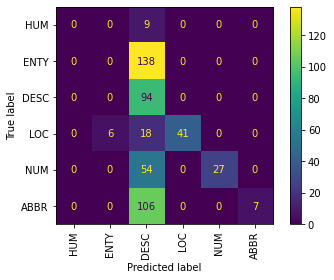

In [119]:
plot_confusion_matrix(predictions) # This is currently wrong